# Imports

In [1]:
using JLD2
using PyPlot
using CSV
using ProgressMeter
using DataFrames
using Statistics
using StatsBase
using Distributions
using Distances

include("../src/modelisation.jl")
using .colocalization_modelisation

In [ ]:
function pad_right(arr::AbstractVector, pad_length::Int, pad_value=0)
    n = length(arr)
    if pad_length <= n
        return arr[1:pad_length]
    else
        return vcat(arr, fill(pad_value, pad_length - n))
    end
end

pad_right (generic function with 2 methods)

# Open simulation files

In [2]:
parameters_path = "/home/flo/Documents/julia/Random co-localization simulation/output/colocalization_simulation_parameters.csv"
result_path = "/home/flo/Documents/julia/Random co-localization simulation/output/"
pairwise_filename = "colocalization_pairwise_counts.jld2"
truth_table_filename = "colocalization_truth_table.jld2"
output_path = "/home/flo/Documents/julia/"

"/home/flo/Documents/julia/"

## Co-localization array

In [3]:
pairwise_data = jldopen(result_path*pairwise_filename, "r") do file
    read(file,"colocalization_counts")
end
simulation_number, distribution_number,_ = size(pairwise_data)

(100000, 7, 7)

In [4]:
truth_table, truth_table_index,shape = jldopen(result_path*truth_table_filename, "r") do file
    println(keys(file))
    read(file,"colocalization_truth_table"), read(file,"colocalization_truth_table_index"), read(file, "shape")
end
simulation_number,spot_per_simulation, distribution_number = size(truth_table)
print("truth_table : ", size(truth_table))
print("truth_table_index : ", size(truth_table_index))

["colocalization_truth_table", "colocalization_truth_table_index", "shape"]
truth_table : (100000, 1510, 7)truth_table_index : (1510,)

## Parameters frame

In [5]:
parameters = sort(CSV.read(parameters_path, DataFrame))
parameters

Row,distribution_id,abudancy
,Int64,Int64
1,1,10
2,2,50
3,3,100
4,4,200
5,5,250
6,6,400
7,7,500


# Model testing for pairs

In [6]:
volume = prod(shape)

24964

### Parametric boostrap

In [7]:
function posterior_predictive_check(expectancy :: Real, std :: Real, data :: Vector, simulation_number = 10000, metric= mean)
    expected_distribution = Normal(expectancy, std)
    sample_size = length(data)

    T_obs = metric(data)
    
    sim_stats = Array{Float64,1}(undef,simulation_number)
    for sim in 1:simulation_number
        y_rep = rand(expected_distribution, sample_size)
        sim_stats[sim] = metric(y_rep)
    end
    println(mean(T_obs .- sim_stats))
    println(sim_stats)
    
    return mean(sim_stats .>= T_obs)
end

posterior_predictive_check (generic function with 3 methods)

In [9]:
distribution_query = 7
distribution_anchor = 6
abundancy1 = parameters[distribution_query, "abudancy"]
abundancy2 = parameters[distribution_anchor, "abudancy"]


data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)
data = reshape(data, length(data))

expectancy = colocalization_modelisation.colocalization_expectancy(
    abundancy1,
    abundancy2,
    volume
)
distrib_std = colocalization_modelisation.colocalization_std(
    abundancy1,
    abundancy2,
    volume
)

posterior_predictive_check(expectancy, distrib_std, data, 10000, mean)



-0.008233442005118557
[7.95183163367778, 7.9496191809495445, 7.946472778326455, 7.952693061296542, 7.9525512175286375, 7.948361374154979, 7.942838069559117, 7.9461228846026035, 7.952716573405323, 7.943280052942563, 7.951796592406558, 7.959979820143723, 7.950020175184608, 7.944769560541913, 7.942733308126435, 7.938325078438081, 7.953372493963482, 7.93389374488092, 7.951511375402115, 7.946182521787761, 7.938776633978638, 7.947898960064824, 7.937774463656917, 7.9516465798661535, 7.94846208144174, 7.954937996090275, 7.937999227075253, 7.960265423115294, 7.958441132181629, 7.964832076693683, 7.954037241724958, 7.949051295256936, 7.952641981616484, 7.9448997896954685, 7.943590095448534, 7.962090180924311, 7.939860841511745, 7.939168911297207, 7.940440580455927, 7.955432536812454, 7.94332608352353, 7.935819608925047, 7.955409383896324, 7.9495093603504685, 7.94344529134024, 7.942646632365971, 7.946127928085919, 7.950266175547514, 7.953921349144827, 7.954452817380464, 7.954952228484325, 7.95470

0.8272

### Parametric boostrap using Chi square distance (Goodness of fit PPC)

To gain confidence the capacity of our model to predict data that follow random co-localization (**i.e. null hypothesis is true**) we perform a prior predictive check.

* First we transform simulation results into a histogram we consider as the observed distribution. (#TODO relaunch simulation and create different replicates using a sampling number consistent with experimentation : *N ~ 100*)  

* Second using same bining as found for observed data (1 bin per frequency found in experiment) calculate expected weights of bins in a normalised distribution  

* Third, sampling accordingly to simulation and experimentation, create simulated replicates and calcul chi square distance to expected weights (distance qualifying similarity of frequency based distribution). The 99th quantile of this distance measurement (discrepancy) is taken as the critical discrepancy. This indicates the distance up to which a distribution still finds itself behaving under the null hypothesis at significance 1%. In other words only 1% of distributions generated under the null hypothesis find themself with a discrepancy higher than the critical value  

* Calcul discrepancy of observed data to expected distribution under the null and see if it pass the test.  

***Note : this test aims at gaining confidence into the fact that the model can be used to predict data that fits correctly data that randomly co-localize; it is not a guarantee that randomly co-localizing molecules perfectly follows the behavior described in the model. However, it shows that using this model to normalize data across cells should be consistant.***


In [12]:
"""
Create bins that have a uniform probability under null distribution : for N bins p= 1/N for any bin
"""
function probability_uniform_binning(expectancy :: Real, std_value :: Real, bin_number = 30)
    expected_distribution = Normal(expectancy, std_value)
    
    # compute the K+1 equally‐spaced quantiles between 0 and 1
    ps = range(0, 1; length=bin_number)
    # invert the CDF at each
    edges = quantile.(Ref(expected_distribution), ps)
    return edges
end


probability_uniform_binning

In [16]:
"""
Expected weights from model for given set of bins (`edges`)
"""
function compute_expected_weights(expectancy::Real, std_value::Real, edges)
    distribution_under_null = Normal(expectancy, std_value)
    bin_number = length(edges) - 1
    
    expected_weights = Array{Float64, 1}(undef, bin_number)
    for bin in 1:bin_number
        expected_weights[bin] = cdf(distribution_under_null, edges[bin+1]) - cdf(distribution_under_null, edges[bin])
    end

    return expected_weights
end

compute_expected_weights

In [14]:
"""
Compute discrepancies from null distribution (model distribution) this is usefull to build a confidence interval to test on.
"""
function compute_discrepancies_from_null(expectancy :: Real, std_value :: Real, sampling_number ::Int, edges, simulation_number = 100000)
    distribution_under_null = Normal(expectancy, std_value)

    expected_weights = compute_expected_weights(expectancy, std_value, edges)

    discrepancies = Array{Float64, 1}(undef, simulation_number)
    for sim in 1:simulation_number
        simulated_hist = fit(
            Histogram,
            rand(distribution_under_null, sampling_number),
            edges
        )
        discrepancies[sim] = chisq_dist(expected_weights, simulated_hist.weights / sampling_number)
    end
    return discrepancies
end
    

compute_discrepancies_from_null

### Colormap for 1% significance test

In [ ]:
distribution_query = 7
distribution_anchor = 5

test_truth_table = Array{Bool, 2}(undef, distribution_number,distribution_number)
test_pvalue_table = Array{Float64, 2}(undef, distribution_number,distribution_number)
@showprogress for distribution_query in 1:distribution_number
for distribution_anchor in 1:distribution_number

    abundancy1 = parameters[distribution_query, "abudancy"]
    abundancy2 = parameters[distribution_anchor, "abudancy"]
    sampling_number = 100 # Note :this will change the power of the test, numerically we can take a very high sampling number but test will be too strong. What is useful is to take something relevant to sample number if future experiment i.e. number of cells per replicate
    
    
    data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)
    data = reshape(data, length(data))
    
    expectancy = colocalization_modelisation.colocalization_expectancy(
        abundancy1,
        abundancy2,
        volume
    )
    distrib_std = colocalization_modelisation.colocalization_std(
        abundancy1,
        abundancy2,
        volume
    )
    data_hist = fit(Histogram, data, nbins=maximum(data) + 1)
    binning = data_hist.edges[1]
    expected_weights = compute_expected_weights(expectancy, distrib_std, binning)
    
    discrepancies = compute_discrepancies_from_null(expectancy, distrib_std, sampling_number, binning)
    discrepancies_critical = quantile(discrepancies, 0.99)
    
    data_discrepancies = chisq_dist(expected_weights, data_hist.weights / sum(data_hist.weights))

    test_truth_table[distribution_query, distribution_anchor] = data_discrepancies < discrepancies_critical #Sucess when we fail to reject null hypothesis
    test_pvalue_table[distribution_query, distribution_anchor] = mean(data_discrepancies .< discrepancies )

end
end

test_truth_table

#TODO : Plot 1-pvalue table which represents the best significance the model pass 

### Overlay simulation and model histograms 

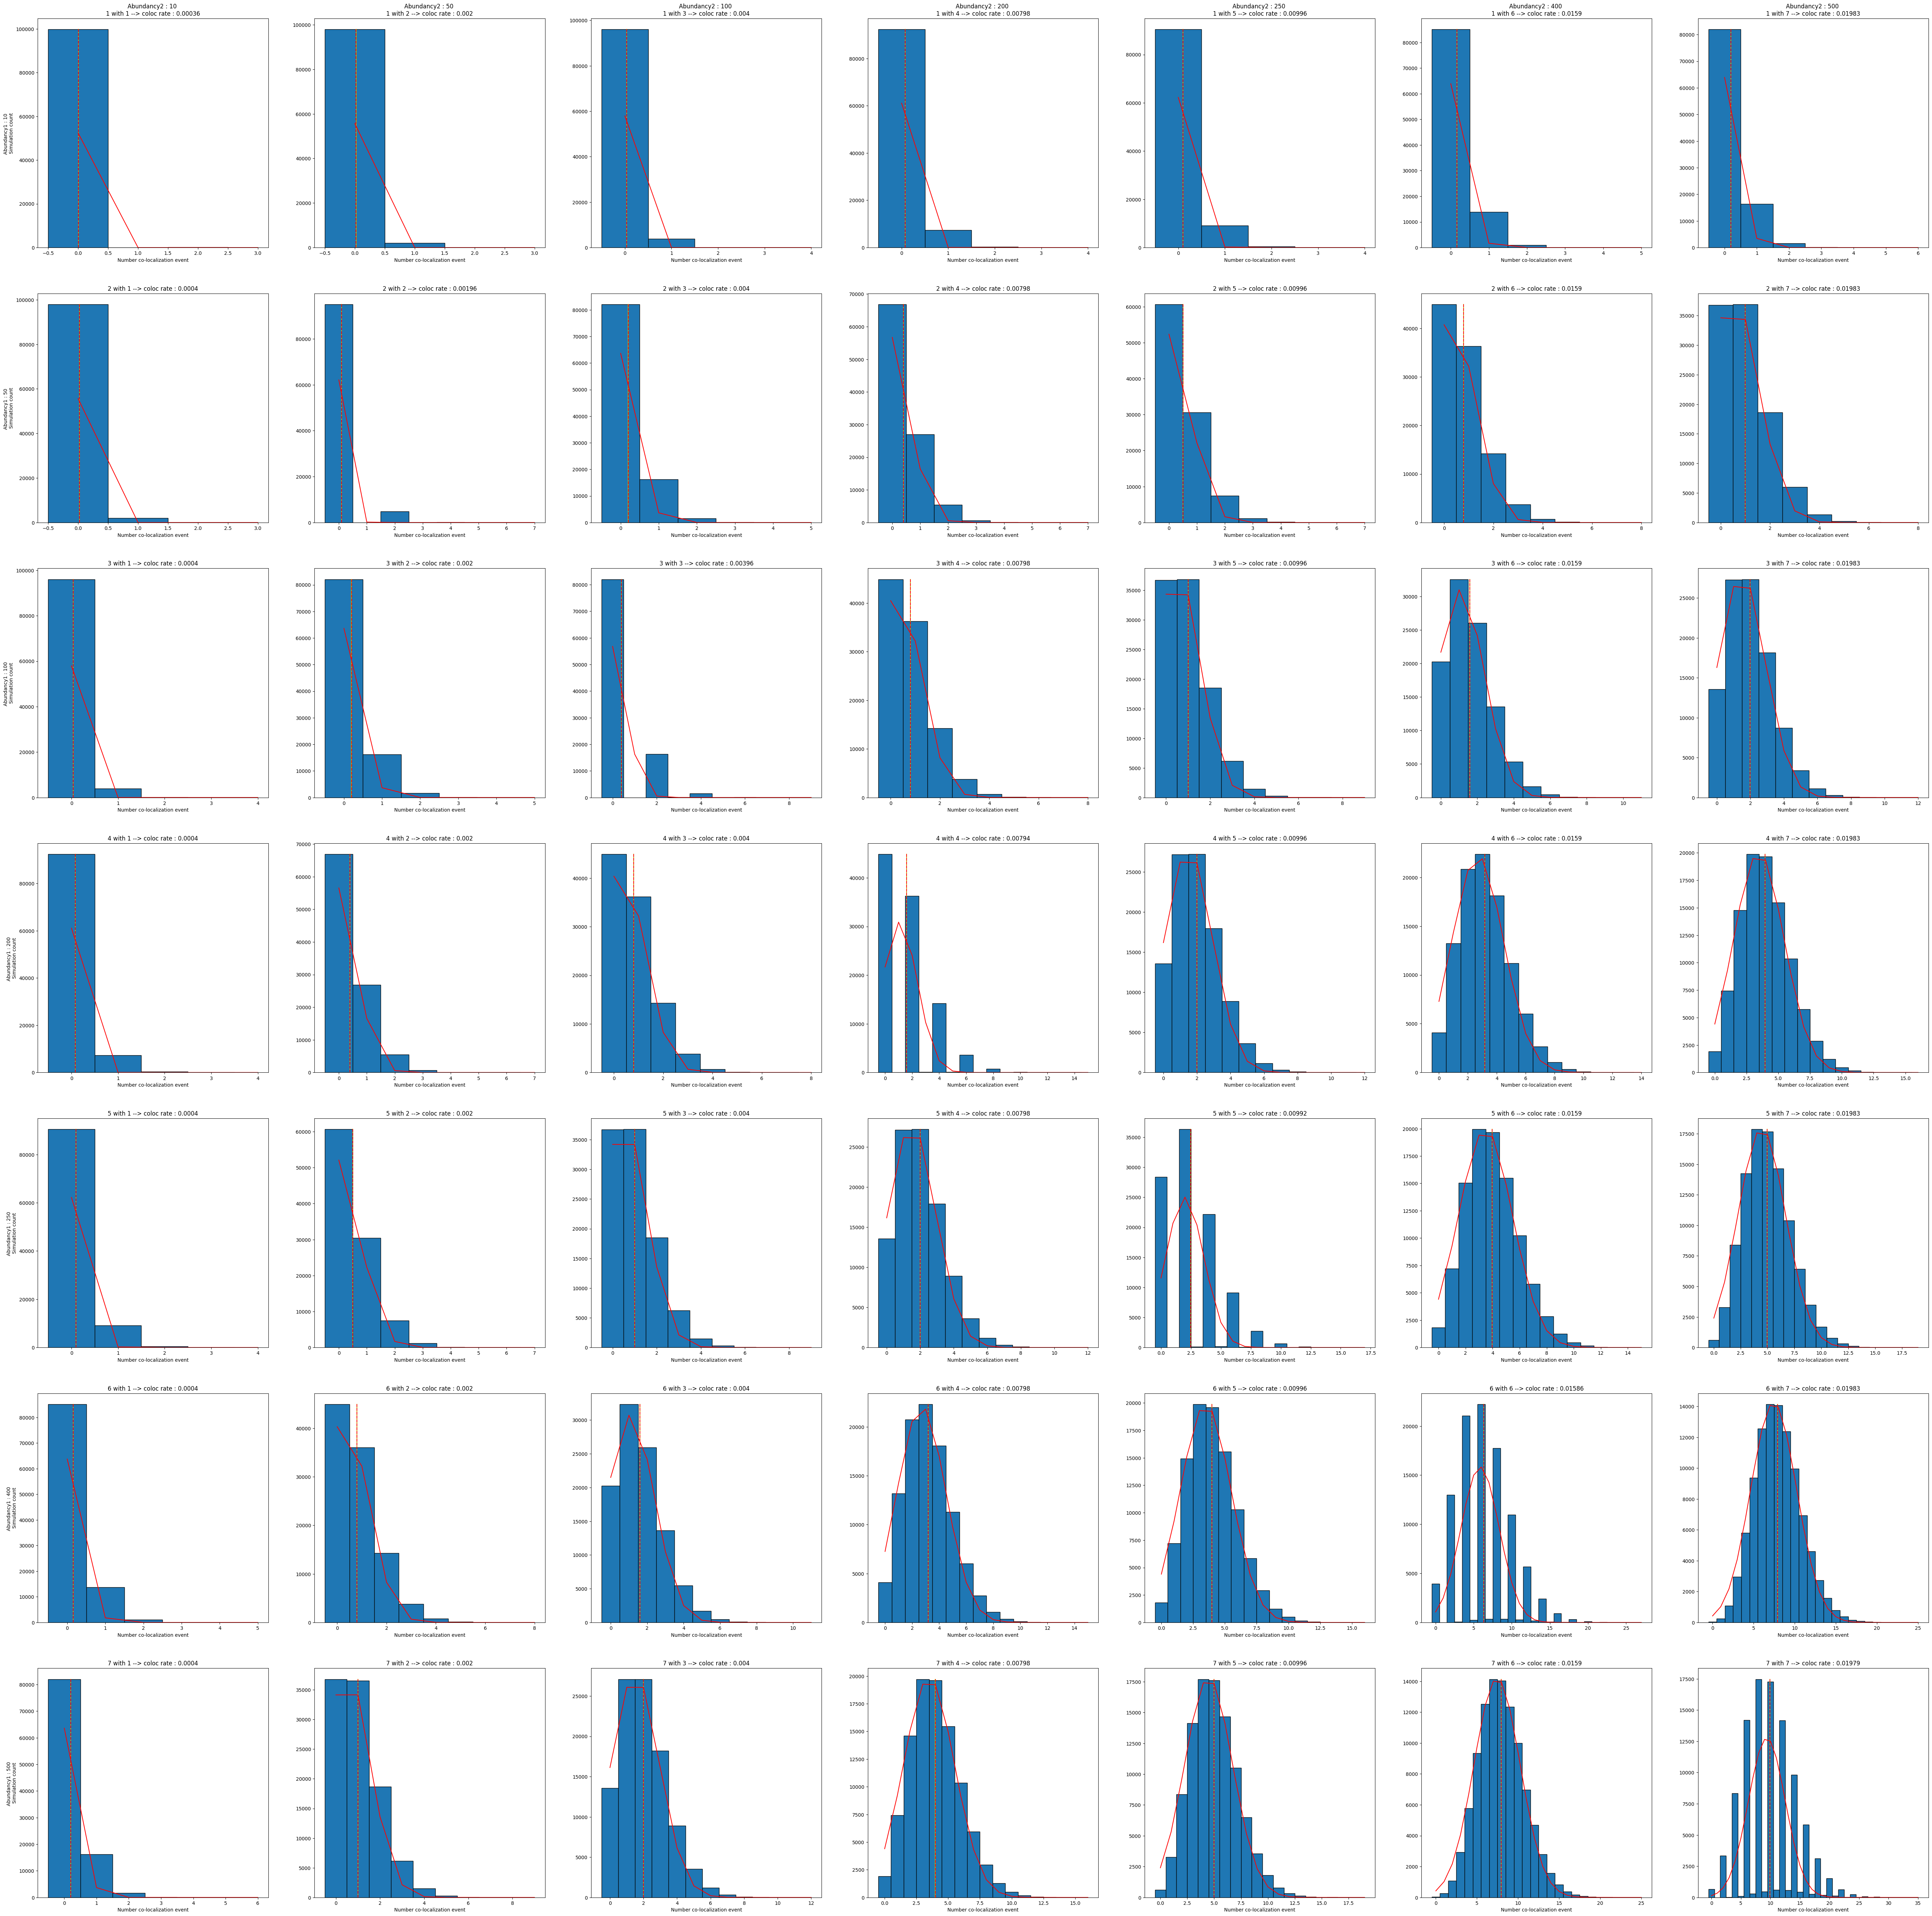

In [17]:
fig, all_axes = subplots(distribution_number,distribution_number, 
figsize=(70,70),
)

ax_idx = 1
for col in 1:distribution_number
    for line in 1:distribution_number
        distribution_query = line
        distribution_anchor = col
        
        abundancy1 = parameters[distribution_query, "abudancy"]
        abundancy2 = parameters[distribution_anchor, "abudancy"]

        if distribution_anchor == distribution_query
            expectancy = colocalization_modelisation.self_colocalization_expectancy(
                abundancy1,
                volume
            )
            std_value = colocalization_modelisation.self_colocalization_std(
                abundancy1,
                volume
            )

        else
            expectancy = colocalization_modelisation.colocalization_expectancy(
                abundancy1,
                abundancy2,
                volume
            )
            std_value = colocalization_modelisation.colocalization_std(
                abundancy1,
                abundancy2,
                volume
            )
        end
        
        expected_distribution = Normal(expectancy, std_value)

        data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)

        #Plotting
        ax = all_axes[ax_idx]

        counts, bins = ax.hist(
            data, 
            bins = 0:maximum(data) + 1, 
            align= "left",
            edgecolor = "black",
            density=0
            )
        ax.plot([mean(data), mean(data)], [0,maximum(counts)], "y")
        ax.plot([expectancy, expectancy], [0,maximum(counts)], "--r")
        counts = pad_right(counts, length(bins), 0)
        counts = Int.(round.(counts))
        
        xrange = bins[1]:last(bins)
        # expected_counts = pdf.(expected_distribution, xrange)
        
        expected_probs = Array{Float64,1}(undef, length(counts))
        for i in 1:(length(counts)-1)
            b0 = bins[i]
            b1 = bins[i+1]
        expected_probs[i] = cdf(expected_distribution, b1) - cdf(expected_distribution, b0)
        end

    expected_counts = expected_probs .* sum(counts)
        
        ax.plot(xrange, expected_counts, "r")


        #axis labels
        coloc_rate = expectancy / abundancy1
        coloc_rate= round(coloc_rate, digits= 5)
        if col == 1 
            ax.set_ylabel("Abundancy1 : $abundancy1 \nSimulation count")
        end
        if line == 1
            ax.set_title("Abundancy2 : $abundancy2 \n$distribution_query with $distribution_anchor --> coloc rate : $coloc_rate") 
        else
            ax.set_title("$distribution_query with $distribution_anchor --> coloc rate : $coloc_rate") 
            
        end
        ax.set_xlabel("Number co-localization event")
        ax_idx = ax_idx +1
    end
end
fig.savefig(output_path*"/Random co-localization simulation/output/paircolocalization.png")
fig